<a href="https://colab.research.google.com/github/Lightola/light-wprk/blob/main/11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [9]:
# Load data
data = pd.read_csv("/content/creditcard.csv")


In [10]:
# Basic info
print(f"Dataset shape: {data.shape}")
print(data['Class'].value_counts())


Dataset shape: (29799, 31)
Class
0.0    29704
1.0       94
Name: count, dtype: int64


In [11]:
# 1. What percentage of transactions are fraudulent?
fraud_percentage = (data['Class'].sum() / len(data)) * 100
print(f"Fraudulent transactions percentage: {fraud_percentage:.4f}%")


Fraudulent transactions percentage: 0.3154%


In [12]:
# 2. Handle Class Imbalance
# Undersample the majority class
fraud = data[data['Class'] == 1]
normal = data[data['Class'] == 0].sample(n=len(fraud), random_state=42)
balanced_data = pd.concat([fraud, normal])

print(f"Balanced dataset shape: {balanced_data.shape}")
print(balanced_data['Class'].value_counts())

# Features and Labels
X = balanced_data.drop('Class', axis=1)
y = balanced_data['Class']

# Standardize 'Amount' and 'Time'
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])
X['Time'] = scaler.fit_transform(X[['Time']])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Balanced dataset shape: (188, 31)
Class
1.0    94
0.0    94
Name: count, dtype: int64


In [14]:
# 3. Train Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# 4. Train Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)



Logistic Regression Report:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95        27
         1.0       0.97      0.93      0.95        30

    accuracy                           0.95        57
   macro avg       0.95      0.95      0.95        57
weighted avg       0.95      0.95      0.95        57


Random Forest Report:
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        27
         1.0       1.00      0.93      0.97        30

    accuracy                           0.96        57
   macro avg       0.97      0.97      0.96        57
weighted avg       0.97      0.96      0.96        57



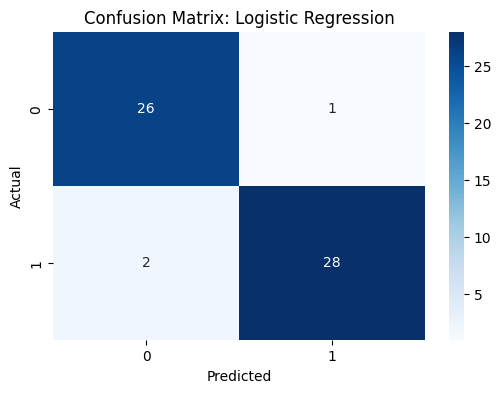

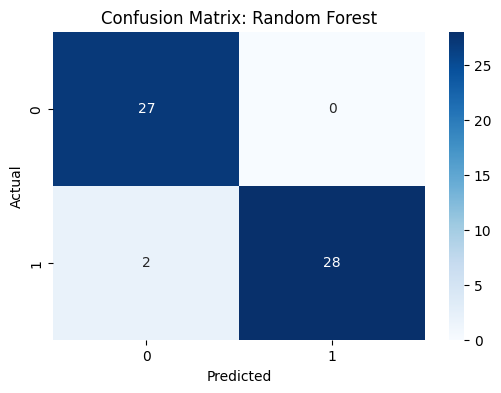

In [15]:
# 5. Evaluate Models
print("\nLogistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

print("\nRandom Forest Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix Plot
def plot_confusion(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion(y_test, y_pred_lr, "Logistic Regression")
plot_confusion(y_test, y_pred_rf, "Random Forest")


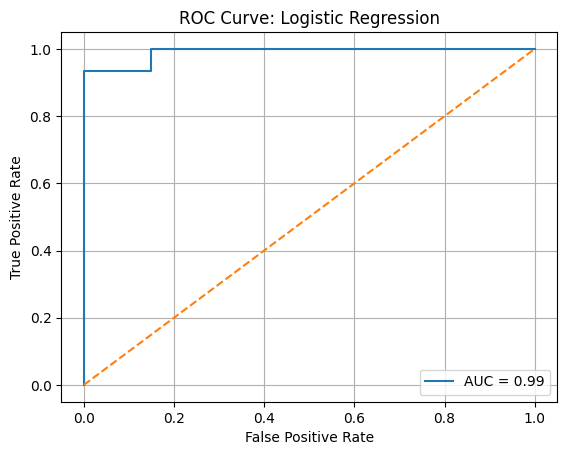

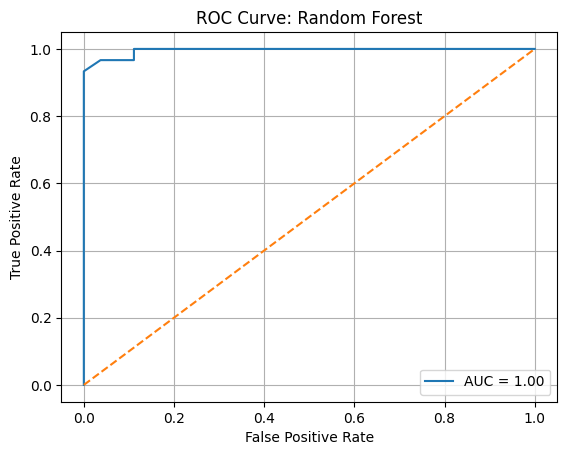

In [16]:
# 6. ROC Curve
def plot_roc_curve(model, X_test, y_test, title):
    y_probs = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0,1],[0,1],'--')
    plt.title(f'ROC Curve: {title}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

plot_roc_curve(lr, X_test, y_test, "Logistic Regression")
plot_roc_curve(rf, X_test, y_test, "Random Forest")



Isolation Forest Report:
              precision    recall  f1-score   support

         0.0       0.48      1.00      0.65        27
         1.0       1.00      0.03      0.06        30

    accuracy                           0.49        57
   macro avg       0.74      0.52      0.36        57
weighted avg       0.75      0.49      0.34        57



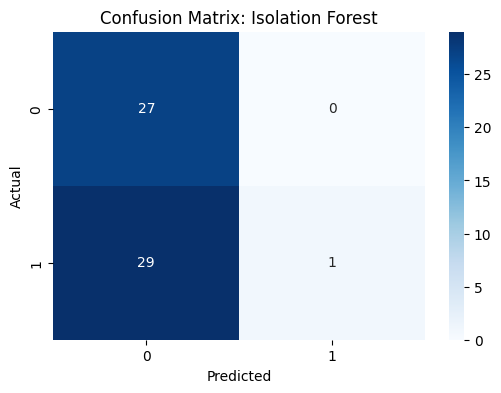

In [17]:
# 7. Anomaly Detection with Isolation Forest
iso = IsolationForest(contamination=0.01)
y_pred_iso = iso.fit_predict(X_test)
# Map IsolationForest output: -1 = anomaly, 1 = normal → convert to 1 (fraud) and 0 (non-fraud)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

print("\nIsolation Forest Report:")
print(classification_report(y_test, y_pred_iso))
plot_confusion(y_test, y_pred_iso, "Isolation Forest")